# Shellfish Toxicity Forecasting with Deep Learning

Ocean Hack Week 2021

Johnathan Evanilla

## Configuración del entorno 

In [1]:
# Establecer la variable de entorno para python
Sys.setenv("RETICULATE_PYTHON"="C:/Users/EQUIPO/.ai-navigator/conda/envs/OHW")

In [2]:
# Cargar los bibliotecas
library(keras)
library(dplyr)
library(keras3)

Registered S3 methods overwritten by 'keras':
  method                               from  
  as.data.frame.keras_training_history keras3
  plot.keras_training_history          keras3
  print.keras_training_history         keras3
  r_to_py.R6ClassGenerator             keras3


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'keras3'


The following objects are masked from 'package:keras':

    %<-active%, %py_class%, activation_elu, activation_exponential,
    activation_gelu, activation_hard_sigmoid, activation_linear,
    activation_relu, activation_selu, activation_sigmoid,
    activation_softmax, activation_softplus, activation_softsign,
    activation_tanh, adapt, application_densenet121,
    application_densenet169, application_densenet201,
    application_efficientnet_b0, application_efficientnet_b1,
    appli

In [3]:
# Cargar la funciones auxiliares
source("tutorial_functions.R")

## Lectura y preprocesamiento

In [4]:
# Leer archivo csv
raw_data <- readr::read_csv("tutorial_data_test.csv") 
#head(raw_data)

Rows: 6273 Columns: 22
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): id, location_id
dbl  (19): gap_days, year, classification, total_toxicity, t1, t2, t3, t4, t...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# Transformación logaritmica
raw_data <- raw_data %>%
    log_inputs(vars = c("t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8", "t9", "t10", "t11", "t12"))

## Generación de imágenes

In [6]:
#Generate images from data
image_list <- make_image_list(raw_data,
                              tox_levels =     c(0,10,30,80),
                              forecast_steps = 1,
                              n_steps =        2,
                              minimum_gap =    4,
                              maximum_gap =    10,
                              toxins =         c("t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8", "t9", "t10", "t11", "t12"),
                              environmentals = c("sst_cum"))

In [7]:
#Splits image_list by year for grouping into train/test data
years <- sapply(image_list, function(x) {return(x$year)})
#str(years)

In [8]:
#image_list <- split(image_list,as.factor(years))
image_list <- split(image_list, years)
#str(image_list)

In [9]:
#configuration
YEARS_TRAINING <-   c("2014", "2016", "2017")
YEARS_TESTING <-    "2015"

In [10]:
#Make a training set
train <- pool_images_and_labels(image_list[YEARS_TRAINING], num_classes = 4)

In [11]:
#Make a test set
test <- pool_images_and_labels(image_list[YEARS_TESTING], num_classes = 4)

In [12]:
#load(file = "data.Rdata")

In [13]:
#dim(raw_data)

In [14]:
#length(years)

In [16]:
model <- keras::keras_model_sequential() %>% 
  keras::layer_dense(units=64, 
                     activation = "relu", 
                     input_shape = dim(train$image)[2],
                     name = "input_layer") %>%
  keras::layer_dropout(rate = 0.4,
                       name = "dropout_1") %>% 
  keras::layer_dense(units=32, 
                     activation = "relu",
                     name = "hidden_1") %>% 
  keras::layer_dropout(rate=0.3,
                       name = "dropout_2") %>% 
  keras::layer_dense(units=16, 
                     activation = "relu",
                     name = "hidden_2") %>% 
  keras::layer_dropout(rate=0.2,
                       name = "dropout_3") %>%
  keras::layer_dense(units = 4, 
                     activation = "softmax",
                     name = "output")

summary(model)

Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)               │ (None, 64)               │         1,728 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_1 (Dropout)               │ (None, 64)               │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ hidden_1 (Dense)                  │ (None, 32)               │         2,080 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_2 (Dropout)               │ (None, 32)               │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ hidden_2 (Dense)                  │ (None, 16)               │           528 │
├─────

In [17]:
str(train)
head(train$labels)

List of 7
 $ labels         : num [1:3413, 1:4] 1 1 0 1 1 1 1 1 1 0 ...
 $ image          : num [1:3413, 1:26] 0 0 0 0.379 0 ...
 $ classifications: num [1:3413] 0 0 2 0 0 0 0 0 0 3 ...
 $ toxicity       : num [1:3413] 0 0 45.21 4.18 2.65 ...
 $ locations      : chr [1:3413] "PSP12.01" "PSP24.13" "PSP10.11" "PSP15.25" ...
 $ dates          : num [1:3413] 16964 16238 17307 17336 17314 ...
 $ scaling_factors: NULL


1,0,0,0
1,0,0,0
0,0,1,0
1,0,0,0
1,0,0,0
1,0,0,0


In [18]:
model %>% keras::compile(optimizer =  "adam",
                         loss =       "categorical_crossentropy", 
                         metrics =    "categorical_accuracy")

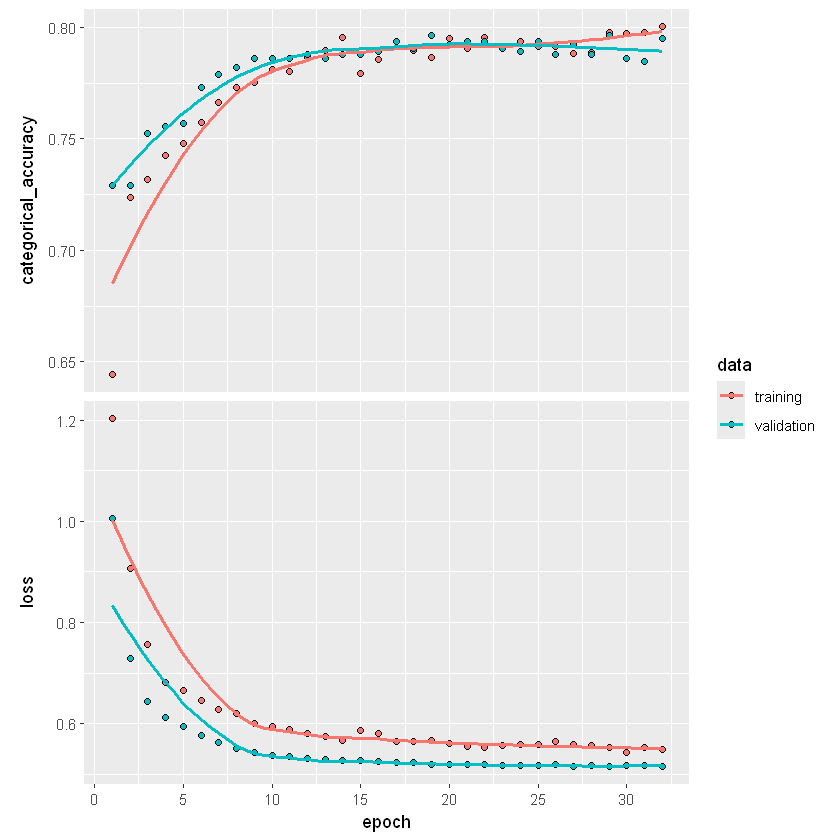

In [19]:
history <- model %>% 
    keras::fit(x = train$image,
               y = train$labels,
               batch_size = 128,
               epochs = 32,
               verbose=1,
               validation_split = 0.2,
               shuffle = TRUE)

plot(history)

In [20]:
metrics <- model %>% 
  keras::evaluate(x = test$image,
                  y = test$labels)

predictions <- model %>% predict(test$image) %>% k_argmax() %>% as.array()
  #keras::predict_classes(test$image)

predicted_probs <- model %>% 
      predict(test$image)

metrics

$categorical_accuracy
[1] 0.8985415

$loss
[1] 0.4105051

In [21]:
predictions

[1] 0 0 0 3 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0
  [38] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 1 0 3 0 0 0 0 1 0 0 0 0
  [75] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 [149] 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 2 0
 [186] 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [223] 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 3
 [297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 [334] 0 0 1 0 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 [408] 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 [445] 0 0 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 [482] 0 0 0 0 0 0 0 0 3 0 0 3 1 0 0 0 0 0 0 0 3 0 0 0 0 2 0 1 0 0 0 1 0 0 0 0 0
 [519] 0 0 0 0 0 0 0 0 1 0 3 0 1 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 [556] 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 [593] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 [630] 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 3 0 0
 [667] 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [704] 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 3 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 2
 [815] 0 0 3 0 0 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 [926] 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0 0 3 0 1
 [963] 0 0 0 0 1 0 3 0 0 0 3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1000] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
[1037] 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1074] 0 0 0 0 0 0 1 0 0 0 0 0 3 1 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
[1111] 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
[1148] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1185] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 0 1 1 0 3 0 0 0 0 0 0 0 0 0
[1222] 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
[1259] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1296] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0
[1333] 0 0 0 3 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
[1370] 0 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
[1407] 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
[1444] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1481] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0
[1518] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0

In [22]:
results <- dplyr::tibble(location = test$locations,
                         date = as.Date(as.numeric(test$dates), origin = as.Date("1970-01-01")),
                         actual_classification = test$classifications,
                         predicted_classification = predictions) %>% 
      dplyr::mutate(prob_0 = predicted_probs[,1]*100,
                    prob_1 = predicted_probs[,2]*100,
                    prob_2 = predicted_probs[,3]*100,
                    prob_3 = predicted_probs[,4]*100)

head(results)

location,date,actual_classification,predicted_classification,prob_0,prob_1,prob_2,prob_3
<chr>,<date>,<dbl>,<dbl[1d]>,<dbl>,<dbl>,<dbl>,<dbl>
PSP26.11,2015-08-11,0,0,93.364000,6.318697,0.2618970,0.055407378
PSP10.25,2015-06-01,0,0,91.342825,7.903836,0.5829752,0.170370587
PSP15.13,2015-09-03,0,0,98.410296,1.573608,0.0143037,0.001797612
PSP12.002,2015-05-26,1,3,4.808777,14.059177,31.7930341,49.339011312
PSP25.02,2015-07-14,0,0,95.986569,3.883649,0.1084881,0.021295386
PSP27.46,2015-08-10,2,1,22.138888,52.622885,19.6957365,5.542495102


In [23]:
metrics[2]

$loss
[1] 0.4105051

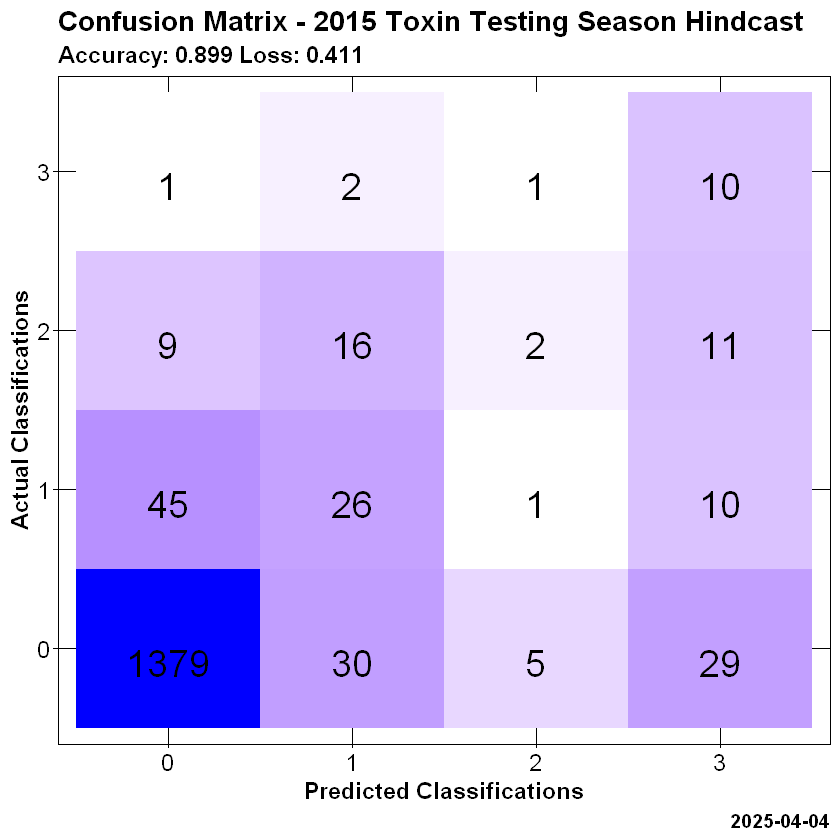

In [24]:
num_levels <- 4
levels <- seq(from=0, to=(num_levels-1))

cm <- as.data.frame(table(predicted = factor(predictions, levels), actual = factor(test$classifications, levels)))
  
confusion_matrix <- ggplot2::ggplot(data = cm,
                                    mapping = ggplot2::aes(x = .data$predicted, y = .data$actual)) +
  ggplot2::geom_tile(ggplot2::aes(fill = log(.data$Freq+1))) +
  ggplot2::geom_text(ggplot2::aes(label = sprintf("%1.0f", .data$Freq)), vjust = 1, size=8) +
  ggplot2::scale_fill_gradient(low = "white", 
                               high = "blue") +
  ggplot2::labs(x = "Predicted Classifications", 
                y = "Actual Classifications", 
                title=paste("Confusion Matrix -", YEARS_TESTING, "Toxin Testing Season Hindcast",sep=" "),
                subtitle=paste("Accuracy:", round(metrics[1]$categorical_accuracy, 3), "Loss:", round(metrics[2]$loss, 3), sep=" "),
                caption=paste(Sys.Date())) +
  ggplot2::theme_linedraw() +
  ggplot2::theme(axis.text=  ggplot2::element_text(size=14),
                 axis.title= ggplot2::element_text(size=14,face="bold"),
                 title =     ggplot2::element_text(size = 14, face = "bold"),
                 legend.position = "none") 

confusion_matrix